# Tutorial 5 :  Neural Process Images

Last Update : 1 September 2019

**Aim**: 
- Test the best models (CCP and AttnNP) on image inputs.

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset 

- MNIST
- CelebA32
- CelebA64

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split

In [5]:
celeba32_train, celeba32_test = train_dev_split(get_dataset("celeba32")(), dev_size=0.1, is_stratify=False)
celeba64_train, celeba64_test = train_dev_split(get_dataset("celeba64")(), dev_size=0.1, is_stratify=False)
#svhn_train, svhn_test = get_dataset("svhn")(split="train"), get_dataset("svhn")(split="test")
mnist_train, mnist_test = get_dataset("mnist")(split="train"), get_dataset("mnist")(split="test")
zs_mmnist_train, zs_mmnist_test = get_dataset("zs-multi-mnist")(split="train"), get_dataset("zs-multi-mnist")(split="test")

# celeba64 not fully trained yet
train_datasets = {"mnist":mnist_train, "celeba32":celeba32_train, "zs-multi-mnist":zs_mmnist_train}
test_datasets = {"mnist":mnist_test, "celeba32":celeba32_test, "zs-multi-mnist":zs_mmnist_test}

INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...


In [6]:
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

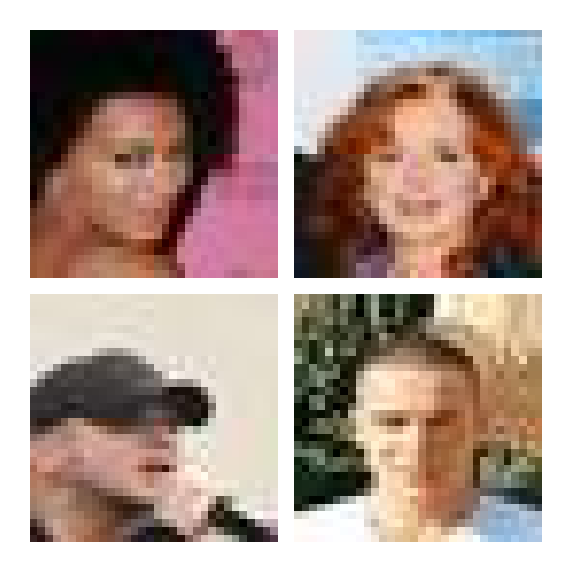

In [7]:
plot_dataset_samples_imgs(celeba32_test, figsize=(9,5))

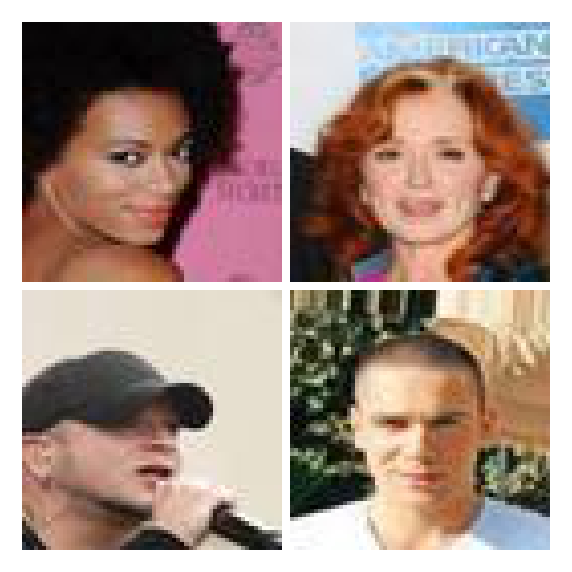

In [8]:
plot_dataset_samples_imgs(celeba64_test, figsize=(9,5))

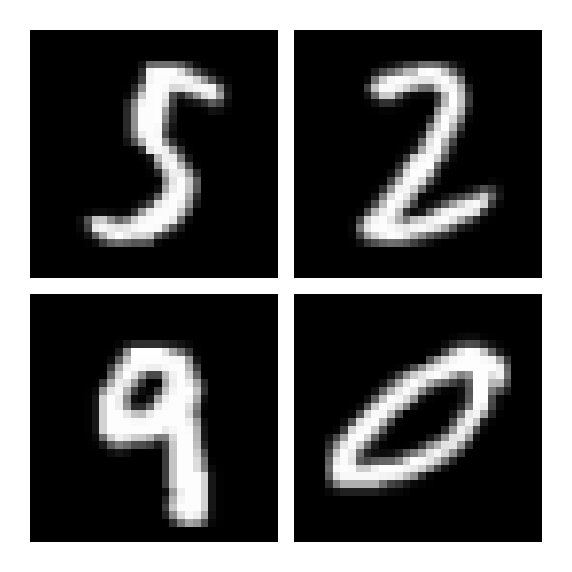

In [9]:
plot_dataset_samples_imgs(mnist_test, figsize=(9,5))

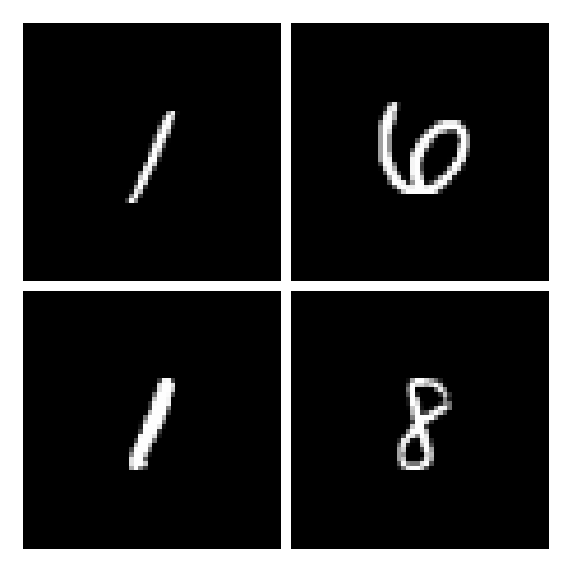

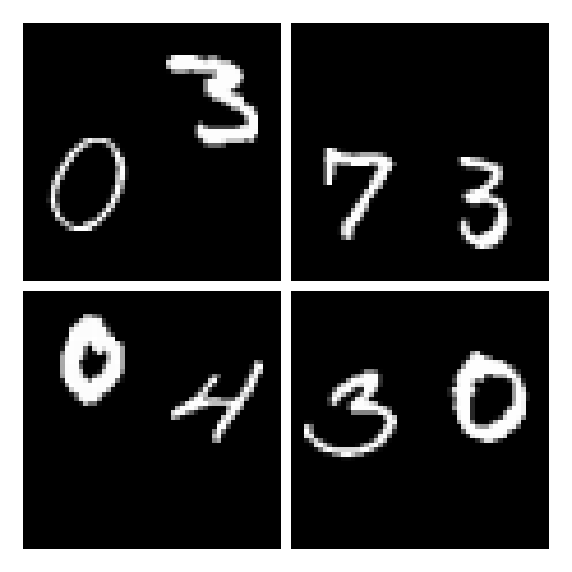

In [10]:
plot_dataset_samples_imgs(zs_mmnist_train, figsize=(9,5))
plot_dataset_samples_imgs(zs_mmnist_test, figsize=(9,5))

In [11]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

# Model

In [12]:
X_DIM = 2  # 2D spatial input 

In [13]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

In [14]:
from neuralproc.utils.helpers import (MultivariateNormalDiag, ProbabilityConverter,
                                      make_abs_conv)

kwargs = dict(r_dim=128,
              # make sure output is in 0,1 as images preprocessed so
              pred_loc_transformer=lambda mu: torch.sigmoid(mu))

# general models
models_general = {}

models_general["AttnCNP"] = partial(AttentiveNeuralProcess, 
                                    x_dim=X_DIM,
                                    attention="transformer", 
                                    **kwargs)


models_general["SelfAttnCNP"] = partial(AttentiveNeuralProcess, 
                                    x_dim=X_DIM,
                                    attention="transformer", 
                                    XYEncoder=merge_flat_input(SelfAttention, is_sum_merge=True),
                                    **kwargs)




# models that take into account the grid
models_grided = {}
models_grided["GridedCCP"] = partial(RegularGridsConvolutionalProcess, 
                                     x_dim=X_DIM,
                                     # depth separable resnet
                                     PseudoTransformer=partial(CNN, 
                                                             ConvBlock=ResConvBlock,
                                                             Conv=torch.nn.Conv2d,
                                                             n_blocks=7,  
                                                             Normalization=torch.nn.BatchNorm2d, #??
                                                             is_chan_last=True,
                                                             kernel_size=11),
                                     **kwargs)

models_grided["GridedUnetCCP"] = partial(RegularGridsConvolutionalProcess, 
                                     x_dim=X_DIM,
                                     # Unet CNN with depth separable resnet blocks
                                     PseudoTransformer=partial(UnetCNN, 
                                                            ConvBlock=ResConvBlock,
                                                            Conv=torch.nn.Conv2d,
                                                            Pool=torch.nn.MaxPool2d,
                                                            max_nchannels=64, # use constant number of channels and chosen to have similar # param
                                                            upsample_mode="bilinear",
                                                            n_blocks=9,  
                                                            Normalization=torch.nn.BatchNorm2d, #??
                                                            is_chan_last=True,
                                                            kernel_size=11),
                                     **kwargs)


In [15]:
from utils.helpers import count_parameters
for k,v in models_general.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))
    
for k,v in models_grided.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))

AttnCNP - N Param: 277606
SelfAttnCNP - N Param: 410214
GridedCCP - N Param: 410999
GridedUnetCCP - N Param: 409975


/master/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=64 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


No hyperparametur tuning was done. The hyperparameters were chosen such that :
- `SelfAttnCNP` was chosen to follow very closely the image model in the paper (the only difference being that it shares an XEncoder which decreases the number of parameter, gives at least as good results, and makes more sense)
- I chose the hyperparameter shuch that the largest internal representation (bottleneck) has 128 dimensions (as in the AttnNP paper).
- The number of layers in `GridedCCP` and `GridedUnetCCP` such that the final model has a simialr number of param than `SelfAttnCNP`.
- `AttnCNP` is `SelfAttnCNP` without self attnetion => less param.



In [16]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

In [17]:
# removing the following until they are fully trained
SelfAttnCNP = models_general.pop("SelfAttnCNP")
GridedUnetCCP = models_grided.pop("GridedUnetCCP")

## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [18]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

In [19]:
# not yet traained on celeba64 (too large memory req)
trainers_general = train_models(train_datasets, 
                                 add_y_dim(models_general, train_datasets),
                                 NeuralProcessLoss,
                                 #test_datasets=test_datasets,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
                                 patience=10,
                                 batch_size=16,
                                 seed=123) 


--- Loading mnist/AttnCNP/run_0 ---

mnist/AttnCNP/run_0 | best epoch: 16 | train loss: -1.1875 | valid loss: -1.2125 | test log likelihood: None

--- Loading celeba32/AttnCNP/run_0 ---

celeba32/AttnCNP/run_0 | best epoch: 20 | train loss: -3.2187 | valid loss: -3.2609 | test log likelihood: None

--- Loading zs-multi-mnist/AttnCNP/run_0 ---



FileNotFoundError: [Errno 2] No such file or directory: 'results/neural_process_imgs/zs-multi-mnist/AttnCNP/run_0/history.json'

In [20]:
# still training celeba64
trainers_grided = train_models(train_datasets, 
                                 add_y_dim(models_grided, train_datasets),
                                 NeuralProcessLoss,
                                 test_datasets=test_datasets,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 


--- Loading mnist/GridedCCP/run_0 ---

mnist/GridedCCP/run_0 | best epoch: 21 | train loss: -1.2541 | valid loss: -1.2729 | test log likelihood: 1.2059

--- Loading celeba32/GridedCCP/run_0 ---

celeba32/GridedCCP/run_0 | best epoch: 11 | train loss: -3.3346 | valid loss: -3.4252 | test log likelihood: 3.2387

--- Loading zs-multi-mnist/GridedCCP/run_0 ---

zs-multi-mnist/GridedCCP/run_0 | best epoch: 11 | train loss: -1.3158 | valid loss: -1.3125 | test log likelihood: 1.2332


In [ ]:
# still training celeba64
trainers_grided = train_models(train_datasets, 
                                 add_y_dim(models_grided, train_datasets),
                                 NeuralProcessLoss,
                                 #test_datasets=test_datasets,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

In [ ]:
trainers = dict()
trainers.update(trainers_general)
trainers.update(trainers_grided)

n_datasets = len(train_datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True)

if n_datasets ==1:
    axes = [axes]

datanames = dict()
for k, trainer in trainers.items():
    data_name = k.split("/")[0]
    datanames[data_name] = datanames.get(data_name, len(datanames))
    i = datanames[data_name]
    plot_losses(trainer.history, 
                title="Losses for {}".format(" ".join(k.split("/")).replace("_", " ")), 
                ax=axes[i],
                mode="validation",
                label_sfx=" {}".format(k))
    #axes[i].set_ylim([-4, -0.])
    #axes[i].set_xlim([0, 25])

# One Shot Inference 

In [21]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE


## Missing at Random

random with only 5 % of the data. The distribution show the distribution of log likelihood for the entire test set. The qualitative results are the images (from left to right) corresponding to 1% 50% and 99% percentile for `GridedCCP` folowed by 1% 50% and 99% percentile for `AttnCCP`.

The first row is `GridedCCP`, while the second is `AttnCCP`.



In [22]:
trainers_compare = trainers_grided.copy()
trainers_compare.update(trainers_general)

NameError: name 'trainers_general' is not defined

In [ ]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_compare.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=VanillaPredictor,
                                     figsize=(11, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

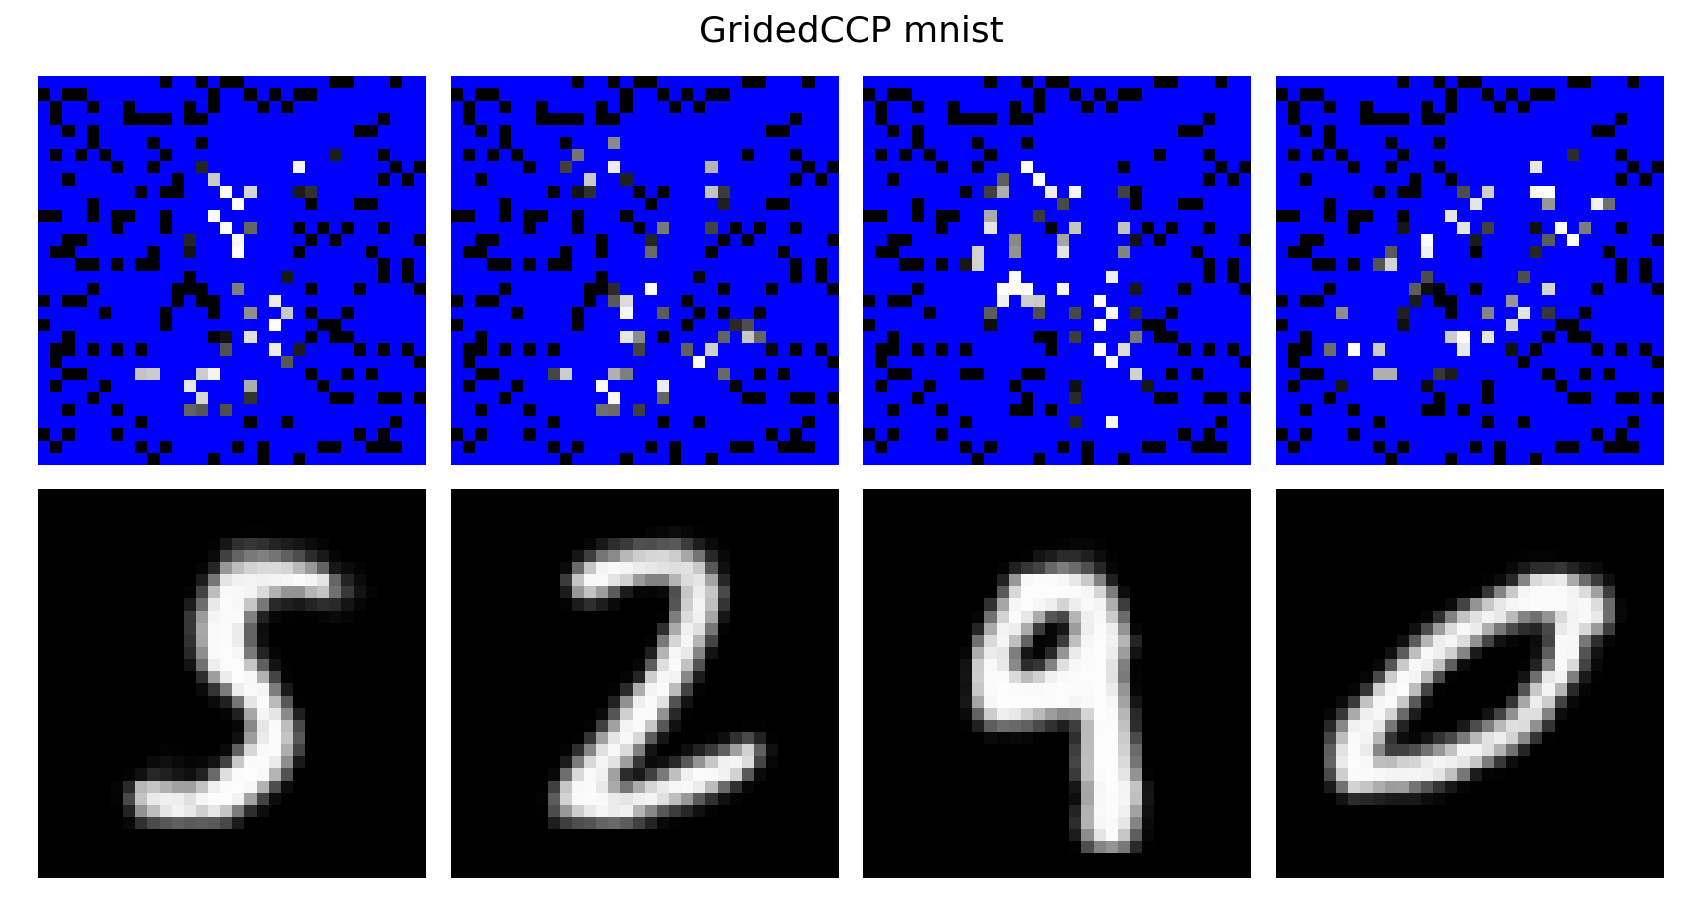

In [34]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=VanillaPredictor,
                             n_plots=4,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

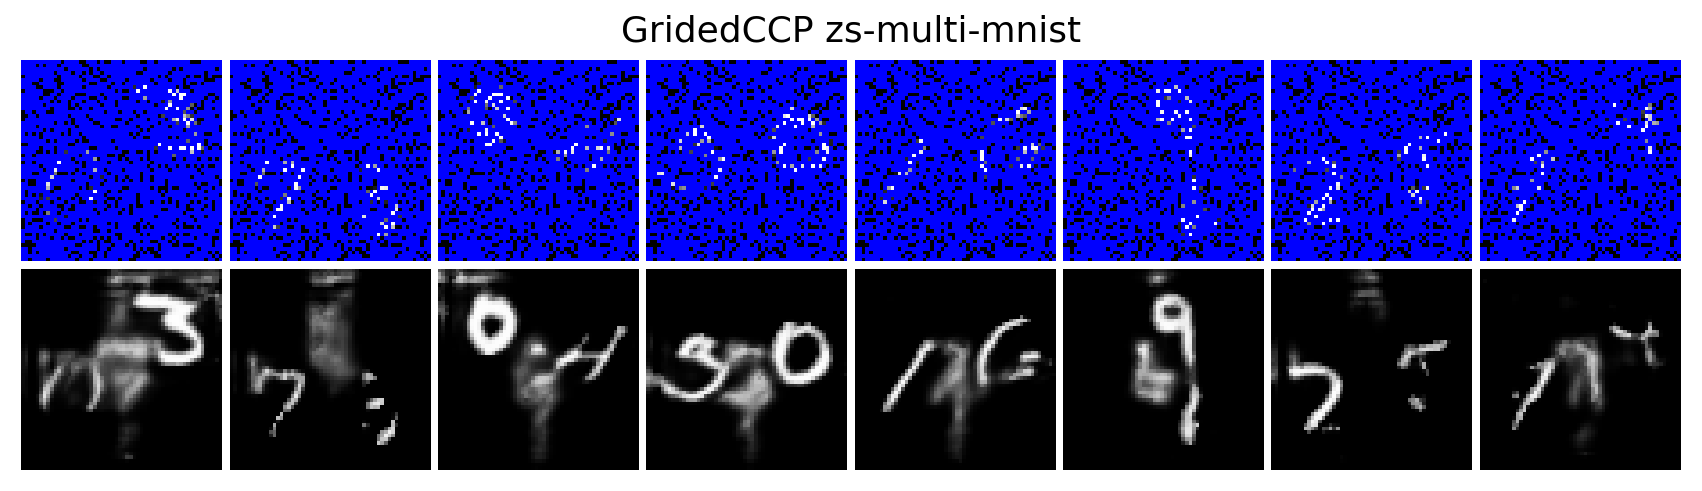

In [36]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "zs-multi-mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=AutoregressivePredictor,
                             n_plots=8,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

In [37]:
d=dict(a=1)

In [38]:
d.copy()

{'a': 1}

## Structured Missing

### Horizontal Half Mask

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_general['{}/AttnCNP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=False, # AttnCNP doesn't assume grid input
                         ax=axes[i])
    
    axes[i].set_title("AttnCNP " + data_name, fontsize=18)

### Vertical Half Mask

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), # change dim=0 for vertical
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0),
                                         target_masker=no_masker), 
                         trainers_general['{}/AttnCNP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=False,
                         ax=axes[i])
    
    axes[i].set_title("AttnCNP " + data_name, fontsize=18)

# Autoregressive Inference 

Autoregressive is as James suggested : predict all neighbors (1 manhattan distance) of context, treat it as context, predict next neighbours.

In [ ]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=AutoregressivePredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), # change dim=0 for vertical
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

# CelebA64

I did not plot all CelebA64, as not all models are trained yet. Here I show `GridedUnetCCP` which finished training.

In [ ]:
train_datasets64 = dict(celeba64=celeba64_train)
test_datasets64 = dict(celeba64=celeba64_test)

In [ ]:
trainers_grided64 = train_models(train_datasets64, 
                                 add_y_dim(dict(GridedUnetCCP=GridedUnetCCP), train_datasets64),
                                 NeuralProcessLoss,
                                 test_datasets=test_datasets64,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

## Oneshot Prediction

In [ ]:
for data_name, test_data in test_datasets64.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided64.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=VanillaPredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

## Autoregressive Prediction

In [ ]:
for data_name, test_data in test_datasets64.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided64.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=AutoregressivePredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)